# Detecting Retina Damage From Optical Coherence Tomography (OCT) Images, using Transfer Learning on VGG16 CNN Model
## Context
Retinal Optical Coherence Tomography (OCT) is an imaging technique used to capture high-resolution cross sections of the retinas of living patients. Approximately 30 million OCT scans are performed each year, and the analysis and interpretation of these images takes up a significant amount of time (Swanson and Fujimoto, 2017).

![Figure 1.](https://i.imgur.com/fSTeZMd.png)

Figure 1. Representative Optical Coherence Tomography Images and the Workflow Diagram \[Kermany et. al. 2018\]

(A) (Far left) Choroidal Neo-Vascularization (CNV) with neovascular membrane (white arrowheads) and associated subretinal fluid (arrows). (Middle left) Diabetic Macular Edema (DME) with retinal-thickening-associated intraretinal fluid (arrows). (Middle right) Multiple drusen (arrowheads) present in early AMD. (Far right) Normal retina with preserved foveal contour and absence of any retinal fluid/edema.

## Content
* The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (NORMAL,CNV,DME,DRUSEN). There are 84,495 X-Ray images (JPEG) and 4 categories (NORMAL,CNV,DME,DRUSEN).
* Images are labeled as (disease)-(randomized patient ID)-(image number by this patient) and split into 4 directories: CNV, DME, DRUSEN, and NORMAL.

* Optical coherence tomography (OCT) images (Spectralis OCT, Heidelberg Engineering, Germany) were selected from retrospective cohorts of adult patients from the Shiley Eye Institute of the University of California San Diego, the California Retinal Research Foundation, Medical Center Ophthalmology Associates, the Shanghai First People’s Hospital, and Beijing Tongren Eye Center between July 1, 2013 and March 1, 2017.

## Acknowledgements
* Data: https://data.mendeley.com/datasets/rscbjbr9sj/2
* Citation: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

## Installing and Importing Libraries

In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn
from skimage.transform import resize
from skimage.color import gray2rgb
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import SVG
import keract
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import applications, optimizers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

/home/u000441/miniconda3/envs/simplon/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2022-11-15 10:57:44.346793: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 10:57:44.506762: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-15 10:57:45.015494: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open 

In [2]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


2022-11-15 10:57:49.311638: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 10:57:49.851924: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38404 MB memory:  -> device: 0, name: A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0


In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
data_dir = "OCT2017 /"
train_data_dir= 'OCT2017 /train/'
val_data_dir= 'OCT2017 /val/'
test_data_dir= 'OCT2017 /test/'
img_width, img_height = 150, 150 
channels = 3
batch_size = 32

### Keras Data Generators

In [6]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    zoom_range= (0.73, 0.9),
    horizontal_flip= True,
    rotation_range= 10,
    width_shift_range= 0.10,
    fill_mode= 'constant',
    height_shift_range= 0.10,   
    brightness_range= (0.55, 0.9),
)

valid_test_datagen = ImageDataGenerator(
    rescale= 1./255, 
)

In [7]:
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    shuffle= True, 
    seed= 1337
) 

valid_generator = valid_test_datagen.flow_from_directory(
    val_data_dir,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    shuffle= True, 
    seed= 1337
)

test_generator = valid_test_datagen.flow_from_directory(  
    test_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,        
    class_mode= 'categorical',
    shuffle= False, 
)

Found 83484 images belonging to 4 classes.
Found 32 images belonging to 4 classes.
Found 968 images belonging to 4 classes.


In [8]:
num_classes = len(train_generator.class_indices)  
train_labels = train_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = valid_generator.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)
nb_train_samples = len(train_generator.filenames)  
nb_valid_samples = len(valid_generator.filenames)
nb_test_samples = len(test_generator.filenames)

# Model
* VGG16 CNN architecture is used for calssification.
* Pretrained on the 'ImageNet' dataset.

In [9]:
vgg16 = VGG16(include_top= False, input_shape= (img_width, img_height, channels), weights= 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

## Test numéro 6  amélioration du modèle de base : 

On modifie l'optimiseur RMSprop au lieu de Adam

In [10]:
model6 = Sequential()

for layer in vgg16.layers:
    model6.add(layer)

for layer in model6.layers:
    layer.trainable= False

model6.add(Flatten(input_shape= (4, 4, 512)))
model6.add(Dropout(0.2))
model6.add(Dense(4,activation='softmax'))

model6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 37, 37, 256)       2

In [11]:
model6.compile(optimizer= keras.optimizers.RMSprop(lr= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

/home/u000441/miniconda3/envs/simplon/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [12]:
numepochs = 7
batch_size = 48
checkpoint_filepath = 'tmp/checkpoint'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
earlystop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
callbacks_list = [earlystop,checkpoint]
history = model6.fit(train_generator,
                        use_multiprocessing=True,
                        workers=8,
                        epochs=numepochs, 
                        batch_size = batch_size,
                        validation_data=valid_generator, 
                        verbose=1,
                        callbacks = callbacks_list)

Epoch 1/7


2022-11-15 10:58:36.727875: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-11-15 10:58:37.648764: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-15 10:58:38.122919: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2609/2609 [==============================] - 82s 30ms/step - loss: 0.6688 - accuracy: 0.7562 - val_loss: 0.4636 - val_accuracy: 0.8125
Epoch 2/7
2609/2609 [==============================] - 78s 29ms/step - loss: 0.5131 - accuracy: 0.8141 - val_loss: 0.3834 - val_accuracy: 0.8438
Epoch 3/7
2609/2609 [==============================] - 77s 29ms/step - loss: 0.4775 - accuracy: 0.8279 - val_loss: 0.4199 - val_accuracy: 0.8438
Epoch 4/7
2609/2609 [==============================] - 79s 30ms/step - loss: 0.4644 - accuracy: 0.8326 - val_loss: 0.3663 - val_accuracy: 0.8438
Epoch 5/7
2609/2609 [==============================] - 78s 29ms/step - loss: 0.4520 - accuracy: 0.8383 - val_loss: 0.3930 - val_accuracy: 0.8438
Epoch 6/7
2609/2609 [==============================] - 78s 29ms/step - loss: 0.4428 - accuracy: 0.8415 - val_loss: 0.3981 - val_accuracy: 0.8750
Epoch 7/7
2609/2609 [==============================] - 78s 29ms/step - loss: 0.4391 - accuracy: 0.8438 - val_loss: 0.4393 - val_accuracy: 0.

### Evaluations on Test Dataset

In [13]:
(eval_loss, eval_accuracy) = model6.evaluate(test_generator, batch_size= batch_size, verbose= 1)
print('Test Loss: ', eval_loss)
print('Test Accuracy: ', eval_accuracy)

31/31 [==============================] - 3s 88ms/step - loss: 0.4474 - accuracy: 0.8130
Test Loss:  0.44743943214416504
Test Accuracy:  0.8130165338516235


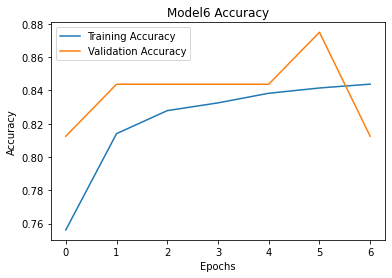

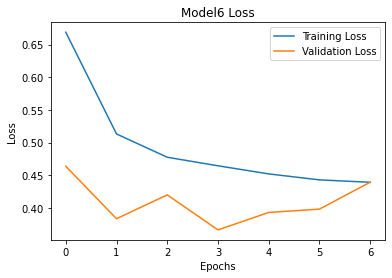

In [14]:
plt.subplot()
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.title('Model6 Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('Model6_acc_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()


plt.subplot()
plt.title('Model6 Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('Model6_loss_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

31/31 [==============================] - 3s 77ms/step


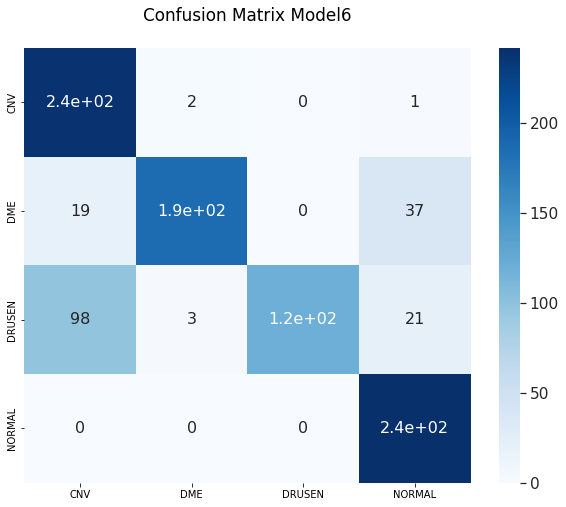

Classification Report Model6

              precision    recall  f1-score   support

         CNV       0.67      0.99      0.80       242
         DME       0.97      0.77      0.86       242
      DRUSEN       1.00      0.50      0.66       242
      NORMAL       0.80      1.00      0.89       242

    accuracy                           0.81       968
   macro avg       0.86      0.81      0.80       968
weighted avg       0.86      0.81      0.80       968



In [15]:
Y_pred = model6.predict(test_generator, nb_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)
df_cm = pd.DataFrame(cm, list(test_generator.class_indices.keys()), list(test_generator.class_indices.keys()))
fig, ax = plt.subplots(figsize=(10,8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap=plt.cm.Blues)
plt.title('Confusion Matrix Model6\n')
plt.savefig('confusion_matrix_model6.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

print('Classification Report Model6\n')
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

### Save the model6

In [17]:
# save model and architecture to single file
model6.save("model6_retinal-oct.h5")
print("Saved model6 to disk")

Saved model6 to disk


### Prediction test6

In [18]:
from PIL import Image
import io
model = tf.keras.models.load_model('model6_retinal-oct.h5')
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
from keras.preprocessing import image

test_image = tf.keras.utils.load_img("OCT2017 /test/CNV/CNV-1016042-1.jpeg", target_size = (150, 150)) 
test_image = tf.keras.utils.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)

#predict the result
result = np.argmax(model.predict(test_image))
print(result)
print(list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(result)])

1/1 [==============================] - 0s 269ms/step
0
CNV
